In [359]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
from geopy.distance import geodesic
import math
import random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

### Datasets

In [8]:
def getTDCSBSchools():
    return pd.read_csv('../res/datasets/schools/TDCSB_Schools.csv', sep = ',')

tdcsbSchools = getTDCSBSchools()

In [10]:
def getPedestrian():
    pedestrian = pd.read_csv('../res/datasets/pedestrian/Pedestrian_Network_Data.csv', sep = ',')
    cols = ['OBJECTID', '_id', 'CROSSWALK_TYPE', 'SIDEWALK_CODE', 'CROSSWALK', 'PX_TYPE', 'PX']
    return pedestrian.drop(cols, axis=1)

In [12]:
coordinates = tdcsbSchools.drop(['_id', 'OBJECTID', 'TCDSB_CODE', 'SCH_NAME','ADDRESS_FULL', 'MUNICIPALITY', 'POSTAL_CODE', 'TCDSB_LEVEL', 'STATUS'], axis = 1)

In [13]:
coordinates = coordinates['geometry'].astype('str')
coordinates = coordinates.apply(lambda x: ast.literal_eval(x))
coordinates = coordinates.apply(pd.Series)

In [39]:
#these are not data frames but instead series 
#be careful when working with them

Latitude = coordinates['coordinates'].apply(lambda x: x[1])
Longitude = coordinates['coordinates'].apply(lambda x: x[0])

### Parameters

In [63]:
STD_DEV = 0.4
PT_DENSITY = 50

### Scoring Functions

In [26]:
def getDistance(origin, stationCor):
    return abs(geodesic(origin, stationCor).meters/1000)

In [80]:
def score(latStation, longStation, latOrigin, longOrigin, stdDev):
    
    stationCor = (latStation, longStation)
    
    totalScore = 0
    count = 0
    
    for Lat, Long in zip(latOrigin, longOrigin):
        origin = (Lat, Long)
        r = getDistance(origin, stationCor)
        # this score function simply uses the traditional gaussian distribution formula,
        # except it extracts all the common parts to be multiplied last for efficiency.
        score =  math.exp(-0.5*((r**2) / (stdDev**2)))
        totalScore += score
            
    #adjustFactor = 210 * 0.9974
    #totalScore = (totalScorePre/adjustFactor)*100
    
    # Multiply common part in gaussian distribution formula
    totalScore *= (1/(stdDev * math.sqrt(2 * math.pi)))
    
    return totalScore

In [323]:
def generateGridScores(upperLatBound, bottomLatBound, leftLongBound, rightLongBound):
    scores = pd.DataFrame(columns = ['lat', 'long', 'score'])

    for lat in np.arange(bottomLatBound, upperLatBound, (upperLatBound-bottomLatBound)/PT_DENSITY):
        for long in np.arange(leftLongBound, rightLongBound, (rightLongBound-leftLongBound)/PT_DENSITY):
            pointScore = score(lat, long, Latitude, Longitude, STD_DEV);
            pointScore = pointScore if pointScore > 0.1 else 0.0;
            pointScoreDict = {'lat' : [lat], 'long' : [long], 'score' : [pointScore]};
            pointScoreDf = pd.DataFrame(data=pointScoreDict)
            scores = pd.concat([scores, pointScoreDf], ignore_index = True)

            # print(score(lat, long, 0.4, Latitude, Longitude))
            # plot like this: lat - bottomLatBound,  long - leftLongBound
    return scores

### Linear Regression

In [350]:
def linearRegression(scores):
    # step 1: don't use points that are very small (threshold)
    threshold = 15
    thresholded_scores = scores.loc[scores['score'] >= threshold]
    #print(thresholded_scores)
    
    regr = LinearRegression()
    lats = thresholded_scores["lat"].values.reshape(-1, 1)
    longs = thresholded_scores["long"].values.reshape(-1, 1)
    regr.fit(lats, longs ) # Score is Squared because sample_weight is square rooted thresholded_scores["score"]
    x_begin = lats[0]
    x_end = lats[-1]
    y_begin = regr.predict(x_begin.reshape(1, -1)).item()
    y_end = regr.predict(x_end.reshape(1, -1)).item()
    
    return (x_begin.item(), x_end.item(), y_begin, y_end)

In [376]:
def polynomialRegression(scores, degree, upperLatBound, bottomLatBound):
    poly = PolynomialFeatures(degree, include_bias=False)
    poly_features = poly.fit_transform(scores["lat"].values.reshape(-1, 1))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, scores["long"], scores["score"])
    x = np.linspace(bottomLatBound, upperLatBound, num=PT_DENSITY)
    y = poly_reg_model.predict(poly.fit_transform(x.reshape(-1, 1)))
    return (x, y)

In [379]:
polyTest = polynomialRegression(YYZ_Scores, 9, YYZ_UpperLatBound, YYZ_BottomLatBound)

### Plotting Functions

In [195]:
def plotScores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.scatter(scores["lat"], scores["long"], scores["score"])
    return ax

In [196]:
def plotScoresWithLine(scores, line):
    ax = plotScores(scores)
    ax.plot([line[0], line[1]], [line[2], line[3]], [0, 0], color='red', linewidth=3)
    return ax

In [197]:
def plotHeatmap(scores, line):
    y_begin = line[2]
    y_end = line[3]
    fig = plt.figure()
    ax = sns.heatmap(scores.pivot("long", "lat", "score"), )
    y_begin_hm = int((y_begin - longs[0]) / (longs[-1] - longs[0]) * PT_DENSITY)
    y_end_hm = int((y_end - longs[0]) / (longs[-1] - longs[0]) * PT_DENSITY)
    ax.plot([0, PT_DENSITY], [y_begin_hm, y_end_hm], linewidth=3, color='r')
    return ax

### Toronto (YYZ)

In [324]:
YYZ_UpperLatBound = 43.806535
YYZ_BottomLatBound = 43.567208
YYZ_LeftLongBound = -79.597003
YYZ_RightLongBound = -79.322181

YYZ_Scores = generateGridScores(YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)

<Axes3DSubplot:>

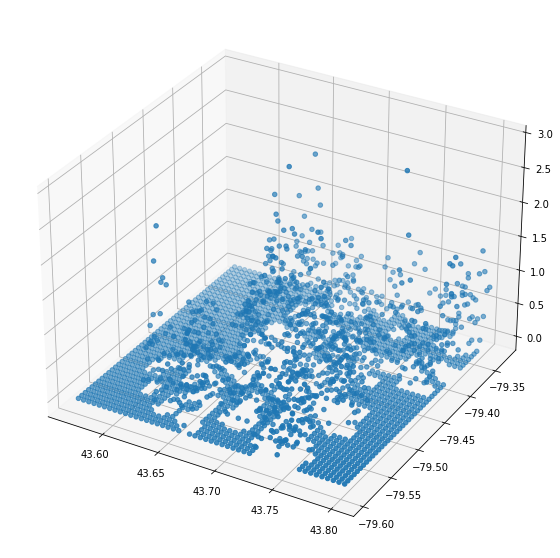

In [325]:
plotScores(YYZ_Scores)

In [336]:
YYZ_Line_1 = linearRegression(YYZ_Scores)

<Axes3DSubplot:>

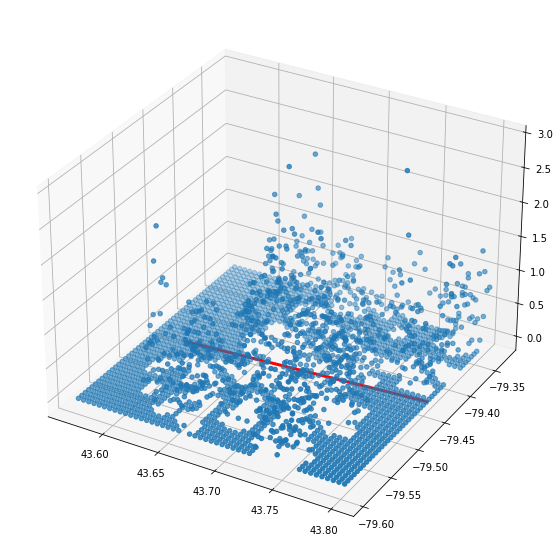

In [337]:
plotScoresWithLine(YYZ_Scores, list(YYZ_Line_1))

<AxesSubplot:xlabel='lat', ylabel='long'>

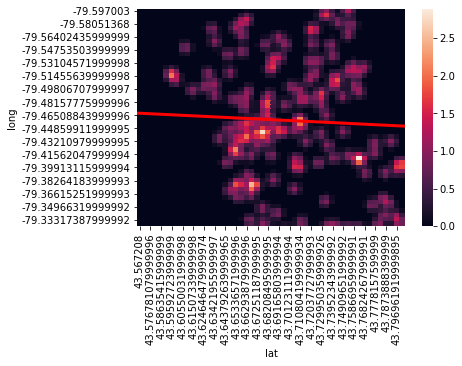

In [338]:
plotHeatmap(YYZ_Scores, YYZ_Line_1)

### Toronto Test (Preliminary Work for Interchanges)

In [339]:
YYZ_T_Scores = YYZ_Scores.copy()
for index, row in YYZ_T_Scores.iterrows():
    YYZ_T_Scores.at[index, 'score'] = (YYZ_T_Scores.at[index, 'score']*2)**2
    #YYZ_T_Scores.at[index, 'score'] += 30*score(row["lat"], row["long"], YYZ_T_Scores["lat"].iloc[1025].reshape(1, -1), YYZ_T_Scores["long"].iloc[1025].reshape(1, -1), 0.5)
    #YYZ_T_Scores.at[index, 'score'] += 30*score(row["lat"], row["long"], YYZ_T_Scores["lat"].iloc[2040].reshape(1, -1), YYZ_T_Scores["long"].iloc[2040].reshape(1, -1), 0.5)
    #YYZ_T_Scores.at[index, 'score'] += -10*score(row["lat"], row["long"], YYZ_T_Scores["lat"].iloc[527].reshape(1, -1), YYZ_T_Scores["long"].iloc[527].reshape(1, -1), 0.9)
    #YYZ_T_Scores.at[index, 'score'] += -10*score(row["lat"], row["long"], YYZ_T_Scores["lat"].iloc[127].reshape(1, -1), YYZ_T_Scores["long"].iloc[127].reshape(1, -1), 0.9)

<Axes3DSubplot:>

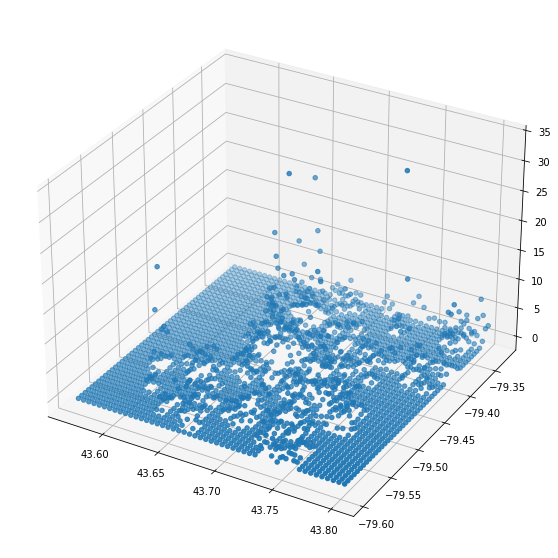

In [340]:
plotScores(YYZ_T_Scores)

In [351]:
YYZ_T_Line_1 = linearRegression(YYZ_T_Scores)

<AxesSubplot:xlabel='lat', ylabel='long'>

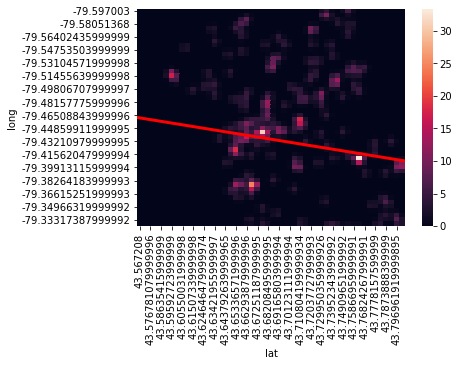

In [352]:
plotHeatmap(YYZ_T_Scores, YYZ_T_Line_1)

In [353]:
YYZ_T_Line_1

(43.59592723999999, 43.76345613999991, -79.45934836347513, -79.40434741799639)

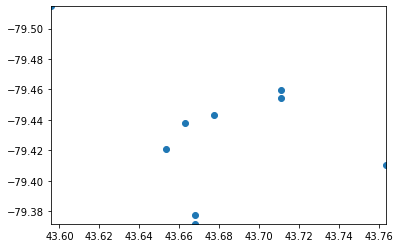

In [354]:
test = YYZ_T_Scores.loc[YYZ_T_Scores['score'] > 15]
plt.axis([min(test['lat']), max(test['lat']), max(test['long']), min(test['long'])])
plt.scatter(test['lat'], test['long'])

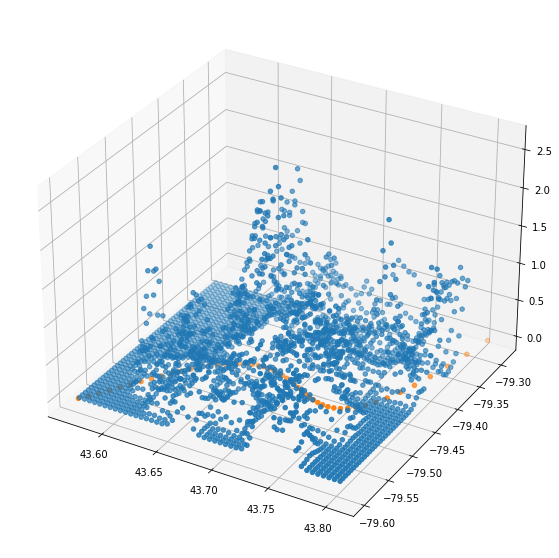

In [380]:
ax = plotScores(scores)
ax.scatter(polyTest[0], polyTest[1], 0)

In [374]:
polyTest

(array([43.567208  , 43.57209222, 43.57697645, 43.58186067, 43.5867449 ,
        43.59162912, 43.59651335, 43.60139757, 43.6062818 , 43.61116602,
        43.61605024, 43.62093447, 43.62581869, 43.63070292, 43.63558714,
        43.64047137, 43.64535559, 43.65023982, 43.65512404, 43.66000827,
        43.66489249, 43.66977671, 43.67466094, 43.67954516, 43.68442939,
        43.68931361, 43.69419784, 43.69908206, 43.70396629, 43.70885051,
        43.71373473, 43.71861896, 43.72350318, 43.72838741, 43.73327163,
        43.73815586, 43.74304008, 43.74792431, 43.75280853, 43.75769276,
        43.76257698, 43.7674612 , 43.77234543, 43.77722965, 43.78211388,
        43.7869981 , 43.79188233, 43.79676655, 43.80165078, 43.806535  ]),
 array([-79.46234017, -79.46234019, -79.46234021, -79.46234022,
        -79.46234023, -79.46234024, -79.46234024, -79.46234025,
        -79.46234025, -79.46234025, -79.46234024, -79.46234024,
        -79.46234024, -79.46234023, -79.46234023, -79.46234022,
        -79.